In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [25]:
# Load dataset
df = pd.read_csv("data/netflix_titles.csv")

# Keep only relevant columns
df = df[['title', 'listed_in', 'duration']].dropna()

# Convert duration from string to float (e.g., "90 min" → 90)
df['duration'] = df['duration'].str.extract('(\d+)').astype(float)

# Split genres (multi-label)
df['genres'] = df['listed_in'].str.split(', ')

# One-hot encode genres
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(df['genres']), columns=mlb.classes_)

# Combine original DataFrame with encoded genres
df = pd.concat([df, genre_encoded], axis=1)
df.drop(['listed_in', 'genres'], axis=1, inplace=True)

# Drop rows with missing values (just in case)
df.dropna(inplace=True)

# Save genre columns for clustering
genre_cols = list(genre_encoded.columns)


In [26]:
# Prepare features: all genres + duration
features = df[genre_cols + ['duration']]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Run KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)


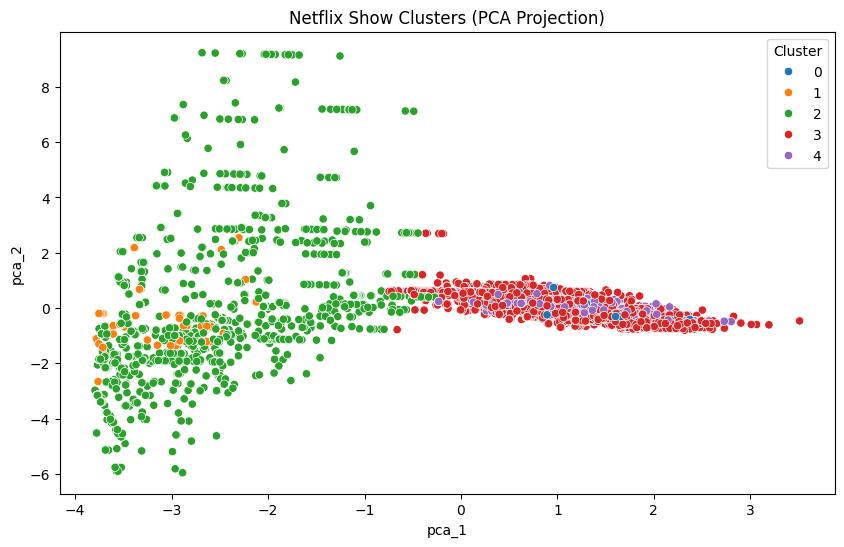

In [27]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)
df['pca_1'] = components[:, 0]
df['pca_2'] = components[:, 1]

# Plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='pca_1', y='pca_2', hue='Cluster', palette='tab10')
plt.title("Netflix Show Clusters (PCA Projection)")
plt.show()


In [28]:
# recoomendation funtion
def recommend_show(df, show_name, n_recommendations=5):
    # Check if the show exists
    if show_name not in df['title'].values:
        return f"❌ Show '{show_name}' not found in dataset."

    # Get the cluster of the selected show
    cluster_id = df[df['title'] == show_name]['Cluster'].values[0]

    # Filter other shows in the same cluster
    recommendations = df[
        (df['Cluster'] == cluster_id) & 
        (df['title'] != show_name)
    ]['title'].sample(n=min(n_recommendations, len(df[df['Cluster'] == cluster_id])-1))

    return recommendations.tolist()


In [29]:
#cluster data save
df.to_csv("netflix_clustered.csv", index=False)

In [30]:
print("Recommended shows:")
for rec in recommend_show(df, 'The Crown'):
    print("✔️", rec)


Recommended shows:
✔️ اشتباك
✔️ One Last Thing
✔️ Roswell, New Mexico
✔️ Too Hot to Handle
✔️ Young & Hungry
